In [1]:
# jupyter autocomplete settings
%config IPCompleter.greedy=True

# import libs
import pandas as pd
import matplotlib.pyplot as plt
import file_selector as selector
from datetime import datetime

# Daten Import

Die nachfolgende Code-Zelle öfnet einen Datei-Dialog um eine Log Datei einzulesen

In [65]:
file_path = selector.gui_fname('../api_test_app/logs/').decode("utf-8")
file_path

'D:/Wichtig/Studium/Studienarbeit/Docs/api_test_app/logs/2021-05-03_12-13-32.csv'

Einlesen der Ausgewälten CSV Datei mit Pandas

In [66]:
df = pd.read_csv(file_path, ';')
# drop trailing empty column
del df['Unnamed: 6']
df = df.sort_values(by='timestamp')
df.head()

,timestamp,status code,request time,server time,request type,function type
6,1620044012859,200,2087,1438.000000,get,/default/compute_node
0,1620044012860,200,649,11.000000,get,/default/fib_node
2,1620044012861,200,1170,500.661460,get,/default/fib_python
4,1620044012861,200,1625,983.061194,get,/default/compute_python
1,1620044013528,200,459,6.000000,get,/default/fib_node


# Daten Vorbereitung

Zuerst wird der absolute Zeitstempel jedes Eintrages in einen relativen Abstand (in Millisekunden) vom ersten Eintrage umgewandelt.

In [67]:
df['function type'] = df['function type'].apply(lambda x: x.split('/')[-1])

start_time = df['timestamp'].iloc[0]  
df['timestamp'] = df['timestamp'].apply(lambda x: (x - start_time))

df.head()

,timestamp,status code,request time,server time,request type,function type
6,0,200,2087,1438.000000,get,compute_node
0,1,200,649,11.000000,get,fib_node
2,2,200,1170,500.661460,get,fib_python
4,2,200,1625,983.061194,get,compute_python
1,669,200,459,6.000000,get,fib_node


# Auswertung

In [68]:
# Konstanten für Plots
legend_offset = 1.3

## Alle gemessenen Daten

Zuerst sollen die server- und client seitigen daten Dargestellt werden.

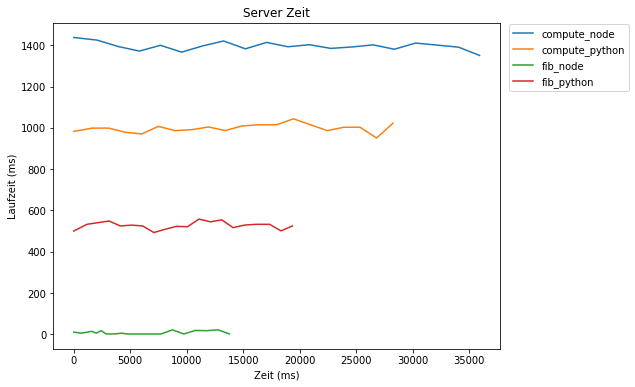

In [69]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df_sub in df.groupby('function type'):
    df_sub.plot(x='timestamp', y='server time', ax=ax, label=label, xlabel='Zeit (ms)', ylabel='Laufzeit (ms)')
    
plt.title('Server Zeit')
plt.legend(bbox_to_anchor=(legend_offset, 1.01), loc='upper right')
plt.show()

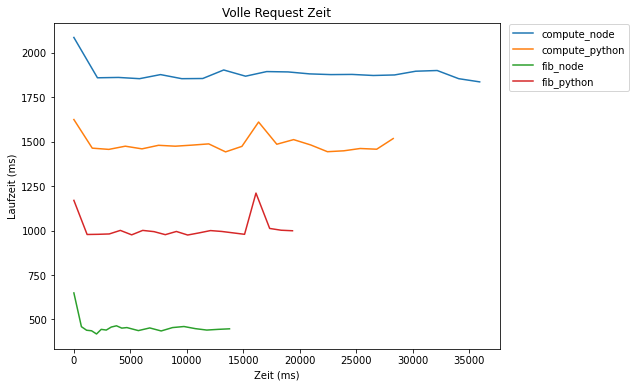

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df_sub in df.groupby('function type'):
    df_sub.plot(x='timestamp', y='request time', ax=ax, label=label, xlabel='Zeit (ms)', ylabel='Laufzeit (ms)', style='-')
    
plt.title('Volle Request Zeit')
plt.legend(bbox_to_anchor=(legend_offset, 1.01), loc='upper right')
plt.show()

# Cold Start
Zur unteruschung eines möglichen Kaltstartes werden nur die ersten 5 Sekunden des Tests angeshen

In [71]:
# Anfangsfenster in ms
window = 5000
# Ausschneiden des Anfangsbereiches aus gesammt Daten
df_start = df.loc[df['timestamp'] < window]
df_start.tail()

,timestamp,status code,request time,server time,request type,function type
21,3949,200,1862,1394.000000,get,compute_node
19,4115,200,1001,525.192716,get,fib_python
18,4242,200,451,6.000000,get,fib_node
22,4554,200,1475,978.936340,get,compute_python
20,4696,200,454,2.000000,get,fib_node


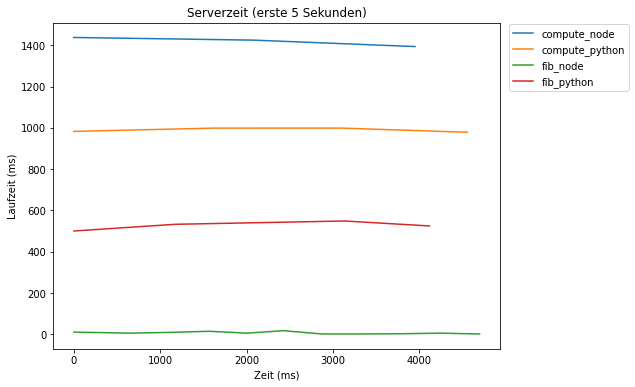

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df_sub in df_start.groupby('function type'):
    df_sub.plot(x='timestamp', y='server time', ax=ax, label=label, xlabel='Zeit (ms)', ylabel='Laufzeit (ms)')
    
plt.title('Serverzeit (erste 5 Sekunden)')
plt.legend(bbox_to_anchor=(legend_offset, 1.01), loc='upper right')
plt.show()

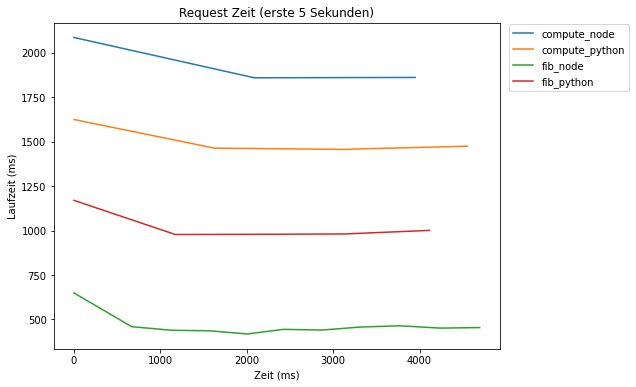

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df_sub in df_start.groupby('function type'):
    df_sub.plot(x='timestamp', y='request time', ax=ax, label=label, xlabel='Zeit (ms)', ylabel='Laufzeit (ms)', style='-')
    
plt.title('Request Zeit (erste 5 Sekunden)')
plt.legend(bbox_to_anchor=(legend_offset, 1.01), loc='upper right')
plt.show()

## Cold Start Abweichung
Abweichung erste Ausführung von der durchschnittlichen Laufzeit, wobei der Durchschnitt ohne die erste Ausführung berechnet wird

In [43]:
# Absolute Abweichung
print('Absolute Abweichung:')
for label, df_sub in df_start.groupby('function type'):
    print(label + ': ' + str(df_sub.iloc[0]['request time'] - df_sub.iloc[1:]['request time'].mean().round()) + 'ms')
    
print('\nRelative Abweichung:')
    
# relative Abweichung
for label, df_sub in df_start.groupby('function type'):
    print(label + ': ' + str(((df_sub.iloc[1:]['request time'].mean() / df_sub.iloc[0]['request time']) * 100).round()) + '%')

Absolute Abweichung:
compute_node: 798.0ms
compute_python: 557.0ms
fib_node: 632.0ms
fib_python: 503.0ms

Relative Abweichung:
compute_node: 70.0%
compute_python: 72.0%
fib_node: 42.0%
fib_python: 67.0%


# Cloudwatch Data
Einlesen der Cloudwatch CSV Datei 

In [12]:
file_path = 'cloudwatch/cloudwatch_c.csv'
df_cloudwatch = pd.read_csv(file_path, ',')
df_cloudwatch.head()

,Timestamp,log,DurationInMS,BilledDurationInMS,MemorySetInMB,MemoryUsedInMB
0,2021-05-03 13:24:48.284,257307065737:/aws/lambda/compute_python,992.76,993,128,51
1,2021-05-03 13:24:46.765,257307065737:/aws/lambda/compute_python,1004.62,1005,128,51
2,2021-05-03 13:24:45.324,257307065737:/aws/lambda/compute_python,998.84,999,128,51
3,2021-05-03 13:24:43.884,257307065737:/aws/lambda/compute_python,993.29,994,128,51
4,2021-05-03 13:24:42.445,257307065737:/aws/lambda/compute_python,1002.77,1003,128,51


Umwandeln des Logfile Namens in Funktionsname durch Wegschneiden des nicht benötigten Pfades

In [13]:
df_cloudwatch['log'] = df_cloudwatch['log'].apply(lambda x: x.split('/')[-1])

Umwandeln des Timestamp (Analog zu client daten)

In [14]:
def parseTimestamp(str):
    return datetime.strptime(str, '%Y-%m-%d %H:%M:%S.%f')

start_time_str = df_cloudwatch['Timestamp'].iloc[0]  
start_time = parseTimestamp(start_time_str)
df_cloudwatch['Timestamp'] = df_cloudwatch['Timestamp'].apply(lambda x: (parseTimestamp(x) - start_time).microseconds // 1000)

# set as index
df_cloudwatch.set_index('Timestamp', inplace=True)
df_cloudwatch = df_cloudwatch.sort_index()

df_cloudwatch.head()

,log,DurationInMS,BilledDurationInMS,MemorySetInMB,MemoryUsedInMB
Timestamp,,,,,
0,compute_python,992.76,993,128,51
1,compute_python,994.78,995,128,50
17,fib_node,34.26,35,128,68
34,fib_python,575.88,576,128,48
40,compute_python,998.84,999,128,51


## Auswertung Cloudwatch

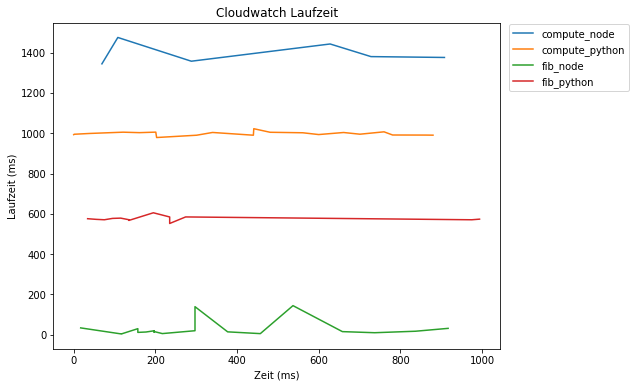

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df_sub in df_cloudwatch.groupby('log'):
    df_sub.plot(y='DurationInMS', ax=ax, label=label, xlabel='Zeit (ms)', ylabel='Laufzeit (ms)')
    
plt.title('Cloudwatch Laufzeit')
plt.legend(bbox_to_anchor=(legend_offset, 1.01), loc='upper right')
plt.show()

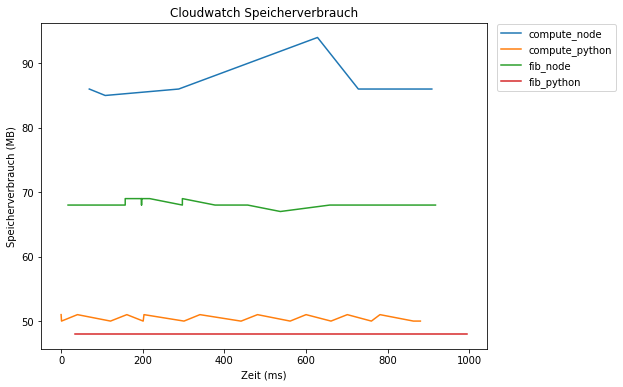

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df_sub in df_cloudwatch.groupby('log'):
    df_sub.plot(y='MemoryUsedInMB', ax=ax, label=label, xlabel='Zeit (ms)', ylabel='Speicherverbrauch (MB)')
    
plt.title('Cloudwatch Speicherverbrauch')
plt.legend(bbox_to_anchor=(legend_offset, 1.01), loc='upper right')
plt.show()